## Data

### Loading Data

In [1]:
import json, pickle
with open('data/TW-stock-news-price/date/NEWS_UDN_ETF_CH.json', 'r') as f:
    news = json.load(f)
with open('data/TW-stock-news-price/date/PRICE_0050.TW_1d.pickle', 'rb') as f:
    price = pickle.load(f)
price_pct = price.pct_change().shift(-1).dropna()
price_pct.head(), price.head()

(Date
 2010-01-04    0.000000
 2010-01-05    0.018584
 2010-01-06   -0.002606
 2010-01-07    0.006098
 2010-01-08    0.002597
 Name: Close, dtype: float64,
 Date
 2010-01-04    56.500000
 2010-01-05    56.500000
 2010-01-06    57.549999
 2010-01-07    57.400002
 2010-01-08    57.750000
 Name: Close, dtype: float64)

### Labelling and to dataframe

In [3]:
from tqdm import tqdm
import pandas as pd
import datetime as dt
import numpy as np

def labelling(price):
    if price > .004:
        return 1
    elif price < -.004:
        return 2
    else:
        return 0
    
df_all = pd.DataFrame(columns=['title', 'content', 'label', 'price'])
for link, infos in tqdm(news.items()):
    """
    If the date has news, then add to the dataframe
    """
    time, title, content = infos
    if title == None or content == None:
        continue
    date = dt.datetime.strptime(time, '%Y-%m-%d %H:%M:%S').date()
    if date in price_pct.index.date:
        if date not in df_all.index:
            price_ = price_pct.loc[str(date)]
            label_ = labelling(price_)
            df_all.loc[date] = [title, content, label_, price_]
        if date in df_all.index:
            df_all.loc[date, 'title'] = df_all.loc[date, 'title'] + '\n' + title
            df_all.loc[date, 'content'] = df_all.loc[date, 'content'] + '\n' + content
len(df_all), df_all.head()


100%|██████████| 6631/6631 [00:07<00:00, 859.34it/s] 


(289,
                                                         title  \
 2024-05-07  經濟熱了 國銀3月放款增4634億創26個月新高\n經濟熱了 國銀3月放款增4634億創26...   
 2024-05-06  股票型 ETF 資金追捧\n股票型 ETF 資金追捧\n固定收益型 美債搶鏡\n六檔台股商品...   
 2024-05-03  三檔台股 ETF 換血\n三檔台股 ETF 換血\nAI需求持續增長 尋找高含量ETF\n1...   
 2024-05-02  七檔台股高息ETF強強滾 00915漲逾18%最猛\n七檔台股高息ETF強強滾 00915漲...   
 2024-04-30  Q1全球黃金需求 寫8年來最高同期紀錄 狂掃貨的買主是他們\nQ1全球黃金需求 寫8年來最高...   
 
                                                       content  label     price  
 2024-05-07  \n\r\n金管會統計，今年3月國銀存款總額增加新台幣5587.06億元，創近3個月新高，反...      0  0.003748  
 2024-05-06  \n\n\r\n過去一周全球股債走揚，整體股票型ETF獲得99.9億美元資金淨流入，中國市場...      1  0.005653  
 2024-05-03  \n三檔台股ETF追蹤指數定期審核結果出爐，包含兆豐永續高息等權（00932）、第一金工業3...      1  0.014336  
 2024-05-02  \n\r\n台股4月以來歷經大起大落，加權指數月線勉力守住紅盤，是2月以來連續第三個月收紅，...      1  0.005123  
 2024-04-30  \n\r\n今年首季全球黃金需求躍增，寫下八年來最高第1季紀錄，主要受到各國央行持續大量購買...      2 -0.013270  )

## Finetune
- [github](https://github.com/yya518/FinBERT/blob/master/finetune.ipynb)

In [4]:
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Split Data

In [5]:
df_all = df_all.sort_index()
df_train = df_all[:100]
df_valid = df_all[100:200]
df_test = df_all[200:]

### To dataset

In [ ]:
text_type = 'title'
dataset_train = Dataset.from_pandas(df_all[[text_type, 'label']])
dataset_val = Dataset.from_pandas(df_valid[[text_type, 'label']])
dataset_test = Dataset.from_pandas(df_test[[text_type, 'label']])

dataset_train = dataset_train.map(lambda e: tokenizer(e[text_type], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e[text_type], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e[text_type], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

### Finetuning

In [7]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

args = TrainingArguments(
        output_dir = 'temp_finetune/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=50,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)


trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)

result = trainer.train()   

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.099489,0.310000
2,No log,1.109271,0.380000
3,No log,1.098917,0.390000
4,No log,1.095661,0.390000
5,No log,1.087813,0.380000
6,No log,1.094368,0.330000
7,No log,1.086946,0.380000
8,No log,1.041052,0.510000
9,No log,1.021185,0.460000
10,No log,1.045407,0.440000


### Evaluation

In [8]:
model.eval()
trainer.predict(dataset_test).metrics

# trainer.save_model('finbert-sentiment/')

{'test_loss': 0.08908287435770035,
 'test_accuracy': 0.9887640449438202,
 'test_runtime': 0.9463,
 'test_samples_per_second': 94.052,
 'test_steps_per_second': 3.17}

### Backtesting

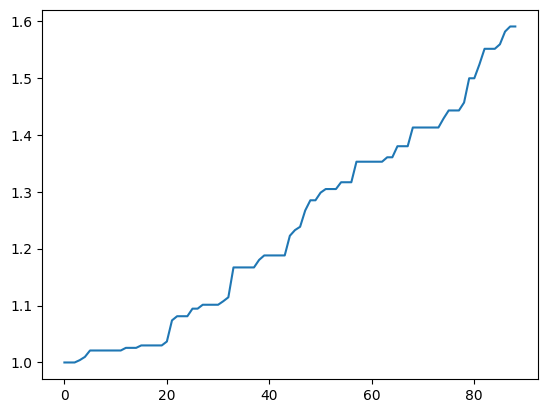

In [9]:
import matplotlib.pyplot as plt
result = np.argmax(trainer.predict(dataset_test)[0], axis = 1)
asset = 1
asset_hist = []
for predict_label, returns in zip(result, df_test['price']):
    asset_hist.append(asset)
    if predict_label == 1:
        asset *= (1+returns)
plt.plot(asset_hist)